In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("/workspace/Weight_compression/Wparam_dataset/hf_model/meta-llama--Llama-2-7b-hf",
                                            torch_dtype='auto',
                                            low_cpu_mem_usage=True,
                                            local_files_only=True,)

Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00,  8.80it/s]


In [10]:
save_dir = './compare_W_plots'
os.makedirs(save_dir, exist_ok=True)

# for i in range(len(model.model.layers)):
for i in [1, 10,31, 0, 30]:    
    for layer in ['q', 'k', 'v', 'o', 'down', 'up', 'gate']:
        path = '/workspace/Weight_compression/hf_model_comp/comp_qtip/ckpt/meta-llama--Llama-2-7b-hf'
        W1 = torch.load(f"{path}/ql_8b/lmbda50/{i}_{layer}.pt")
        W2 = torch.load(f"{path}/ql_8b_col_norm/lmbda50/{i}_{layer}.pt")
        W3 = torch.load(f"{path}/ql_8b_row_norm/lmbda50/{i}_{layer}.pt")

        W1 = W1['W_hat']
        W2 = W2['W_hat']
        W3 = W3['W_hat']

        try:
            W = model.state_dict()[f'model.layers.{i}.self_attn.{layer}_proj.weight']
        except:
            W = model.state_dict()[f'model.layers.{i}.mlp.{layer}_proj.weight']
            
        W_flat = W.view(-1).cpu()
        W1_flat = W1.view(-1).cpu()
        W2_flat = W2.view(-1).cpu()
        W3_flat = W3.view(-1).cpu()
        x_vals = W_flat ** 2
        se1 = (W_flat - W1_flat) ** 2
        se2 = (W_flat - W2_flat) ** 2
        se3 = (W_flat - W3_flat) ** 2
        ymax = torch.max(torch.cat([se1, se2, se3])).item()
        
        fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
        axs[0].scatter(x_vals, se1, alpha=0.3, s=10)
        axs[0].set_title('W vs W1')
        axs[0].set_xlabel('|W|^2')
        axs[0].set_ylabel('Squared Error')
        axs[0].set_ylim(0, ymax)

        axs[1].scatter(x_vals, se2, alpha=0.3, s=10)
        axs[1].set_title('W vs W2')
        axs[1].set_xlabel('|W|^2')
        axs[1].set_ylim(0, ymax)

        axs[2].scatter(x_vals, se3, alpha=0.3, s=10)
        axs[2].set_title('W vs W3')
        axs[2].set_xlabel('|W|^2')
        axs[2].set_ylim(0, ymax)

        plt.suptitle(f'Layer {i} - {layer} - Squared Error vs |W|^2', fontsize=14)
        plt.tight_layout()

        # 파일 저장
        filename = f"{i}_{layer}_se_vs_W^2.png"
        plt.savefig(os.path.join(save_dir, filename), dpi=300)
        plt.close()

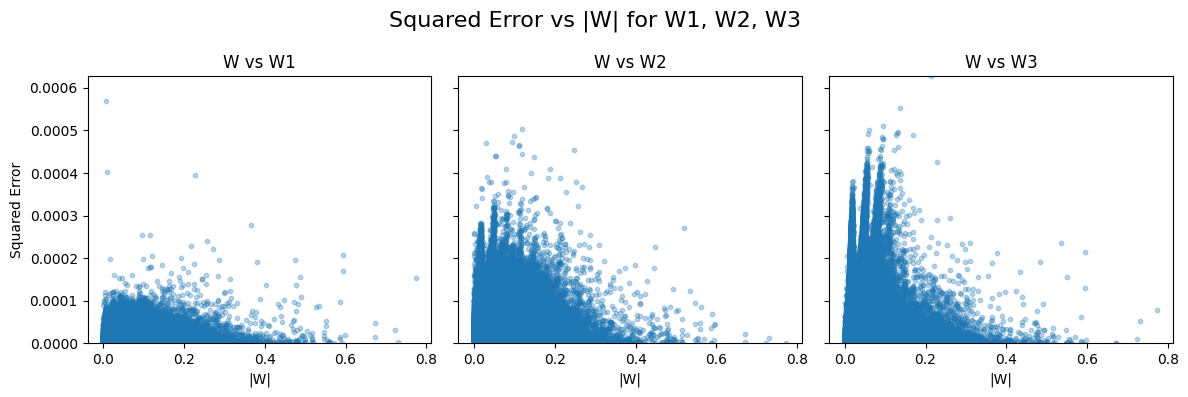

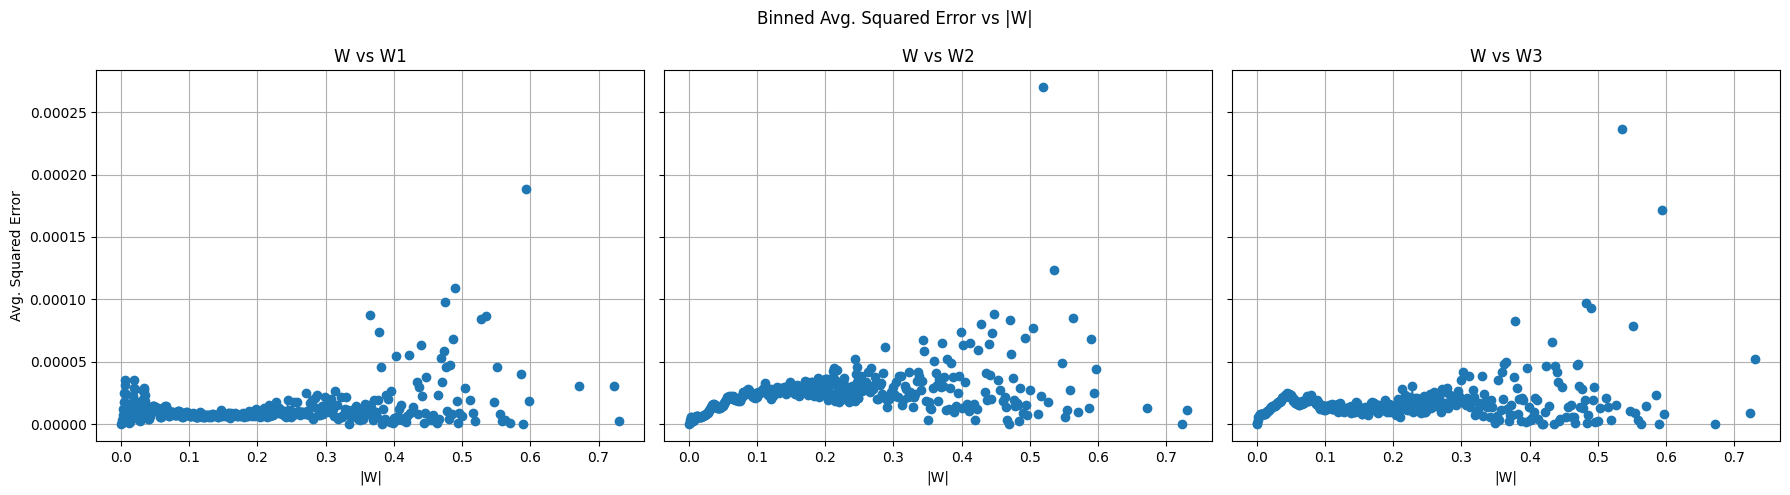

In [14]:
import torch
import matplotlib.pyplot as plt

# 데이터 펼치기 및 CPU로 이동
W_flat = W.view(-1).cpu()
W1_flat = W1.view(-1).cpu()
W2_flat = W2.view(-1).cpu()
W3_flat = W3.view(-1).cpu()

# 절댓값 및 squared error 계산
x_vals = W_flat.abs()
se_list = [
    (W_flat - W1_flat) ** 2,
    (W_flat - W2_flat) ** 2,
    (W_flat - W3_flat) ** 2,
]

# bin 설정
n_bins = 1000
bins = torch.linspace(x_vals.min(), x_vals.max(), n_bins + 1)

# bin별 평균 계산 함수
def compute_bin_avg(x_vals, errors, bins):
    bin_centers = []
    bin_means = []

    for i in range(len(bins) - 1):
        mask = (x_vals >= bins[i]) & (x_vals < bins[i + 1])
        if mask.sum() > 0:
            bin_centers.append(((bins[i] + bins[i + 1]) / 2).item())
            bin_means.append(errors[mask].mean().item())
        else:
            bin_centers.append(((bins[i] + bins[i + 1]) / 2).item())
            bin_means.append(float('nan'))  # skip empty bins

    return bin_centers, bin_means

# 플롯
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

titles = ['W1', 'W2', 'W3']
for i, se in enumerate(se_list):
    bin_x, bin_y = compute_bin_avg(x_vals, se, bins)
    axs[i].plot(bin_x, bin_y, marker='o')
    axs[i].set_title(f'W vs {titles[i]}')
    axs[i].set_xlabel('|W|')
    axs[i].grid(True)

axs[0].set_ylabel('Avg. Squared Error')
plt.suptitle('Binned Avg. Squared Error vs |W|')
plt.tight_layout()
plt.show()
